## Import Libraries


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
import keras
from keras import ops
from keras import layers

2024-05-12 08:19:07.362478: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 08:19:07.362605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 08:19:07.485191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Captcha data

In [2]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  10.6M      0 --:--:-- --:--:-- --:--:-- 10.6M


## Preprocessing datas

In [3]:
base_path = '/kaggle/working/captcha_images_v2'
images = [os.path.join(base_path, path) for path in os.listdir(base_path)]
labels = [path.split('/')[4].split('.')[0] for path in images]
characters = sorted(list(set([char for label in labels for char in label])))

In [4]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [5]:
batch_size = 16
img_width = 160
img_height = 50
downsample_factor = 4
max_length = max([len(label) for label in labels])

In [6]:
char_to_num = layers.StringLookup(vocabulary=characters)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)
# char_to_num = {char:i+1 for i, char in enumerate(characters)}
# char_to_num.update({'[UNK]':0})
# num_to_char = {i+1:char for i, char in enumerate(characters)}
# num_to_char.update({0:'[UNK]'})

In [7]:
char_to_num('y').numpy(), num_to_char(9).numpy()

(19, b'c')

In [8]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    indices = np.arange(len(images))
    if shuffle: np.random.shuffle(indices)
    x_train, y_train = images[indices[:int(train_size * len(images))]], labels[indices[:int(train_size * len(images))]]
    x_val, y_val = images[indices[int(train_size * len(images)):]], labels[indices[int(train_size * len(images)):]]
    return x_train, x_val, y_train, y_val

In [9]:
x_train, x_val, y_train, y_val = split_data(np.array(images), np.array(labels))

In [10]:
list(zip(*(x_train, y_train)))

[('/kaggle/working/captcha_images_v2/ngn26.png', 'ngn26'),
 ('/kaggle/working/captcha_images_v2/m2576.png', 'm2576'),
 ('/kaggle/working/captcha_images_v2/xnn4d.png', 'xnn4d'),
 ('/kaggle/working/captcha_images_v2/pmf5w.png', 'pmf5w'),
 ('/kaggle/working/captcha_images_v2/6mn8n.png', '6mn8n'),
 ('/kaggle/working/captcha_images_v2/fp762.png', 'fp762'),
 ('/kaggle/working/captcha_images_v2/8npe3.png', '8npe3'),
 ('/kaggle/working/captcha_images_v2/cwdnx.png', 'cwdnx'),
 ('/kaggle/working/captcha_images_v2/7y2x4.png', '7y2x4'),
 ('/kaggle/working/captcha_images_v2/nm46n.png', 'nm46n'),
 ('/kaggle/working/captcha_images_v2/pgm2e.png', 'pgm2e'),
 ('/kaggle/working/captcha_images_v2/ndg2b.png', 'ndg2b'),
 ('/kaggle/working/captcha_images_v2/x76mn.png', 'x76mn'),
 ('/kaggle/working/captcha_images_v2/xcmbp.png', 'xcmbp'),
 ('/kaggle/working/captcha_images_v2/excmn.png', 'excmn'),
 ('/kaggle/working/captcha_images_v2/c2yn8.png', 'c2yn8'),
 ('/kaggle/working/captcha_images_v2/nmw46.png', 'nmw46'

## Make dataset

In [11]:
# If use sparse_categorical_crossentropy:
def encode_single_sample(img, label):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = ops.transpose(img, axes=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    return img, label
# If use categorical_crossentropy:
# def encode_single_sample(img, label):
#     img = tf.io.read_file(img)
#     img = tf.image.decode_png(img, channels=1)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img = tf.image.resize(img, [img_height, img_width])
#     img = ops.transpose(img, axes=[1, 0, 2])
#     label = keras.utils.to_categorical(char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8')), num_classes=len(characters)+1)
#     return img, label

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

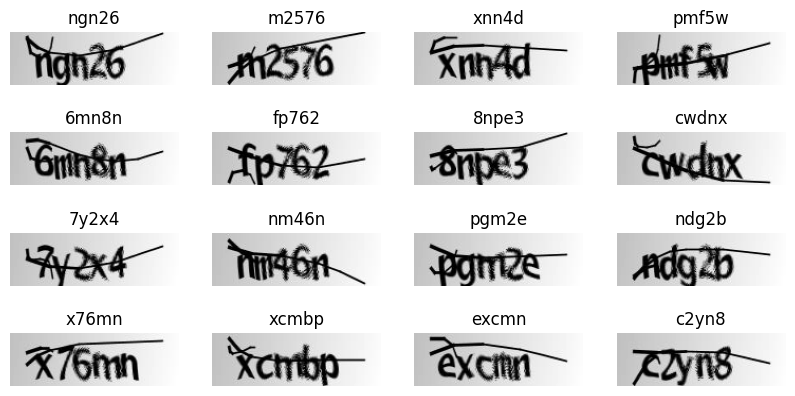

In [13]:
batch_data = next(iter(train_dataset))
images, labels = batch_data
_, axes = plt.subplots(4, 4, figsize=(10, 5))
for i in range(16):
    img = (images[i] * 255).numpy().astype('uint8')
    lbl = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode('UTF-8')
    axes[i // 4, i % 4].imshow(img[:, :, 0].T, cmap='gray')
    axes[i // 4, i % 4].set_title(lbl)
    axes[i // 4, i % 4].axis('off')

## Make model

In [14]:
new_shape = (img_width // 16, (img_height // 16) * 256)
nclasses = len(char_to_num.get_vocabulary())

model = keras.models.Sequential([
    layers.Input(shape=(img_width, img_height, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Reshape(target_shape=new_shape),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPool1D(2),
    layers.Dropout(0.5),
    layers.Dense(nclasses, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 6, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 6, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 3, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 768)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5, 20)          │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,212 (1.95 MB)

 Trainable params: 512,212 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epochs = 100
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.1, )
]
metrics = ['accuracy',]
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=metrics)

## Train model

In [16]:
hitory = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/100


2024-05-12 08:19:28.269390: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.14559, expected 0.597121
2024-05-12 08:19:28.269438: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.72429, expected 2.17582
2024-05-12 08:19:28.269454: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.10205, expected 1.55357
2024-05-12 08:19:28.269479: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.11026, expected 1.56179
2024-05-12 08:19:28.269491: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.42224, expected 1.87377
2024-05-12 08:19:28.269501: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.90732, expected 1.35885
2024-05-12 08:19:28.269512: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.03827, expected 1.48979
2024-05-12 08:19:28.269523: E external/local_xla/xla/s

32/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0567 - loss: 2.9904

I0000 00:00:1715501972.955721      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0597 - loss: 2.9876

2024-05-12 08:19:34.573624: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.08538, expected 1.47558
2024-05-12 08:19:34.573688: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.25925, expected 2.64945
2024-05-12 08:19:34.573704: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.77766, expected 2.16786
2024-05-12 08:19:34.573718: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.47117, expected 1.86137
2024-05-12 08:19:34.573729: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.6854, expected 2.0756
2024-05-12 08:19:34.573740: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.54653, expected 1.93673
2024-05-12 08:19:34.573750: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.4987, expected 1.8889
2024-05-12 08:19:34.573762: E external/local_xla/xla/servic

59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.0604 - loss: 2.9868 - val_accuracy: 0.0885 - val_loss: 2.9588 - learning_rate: 0.0010
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0957 - loss: 2.9609 - val_accuracy: 0.0846 - val_loss: 3.0217 - learning_rate: 0.0010
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1028 - loss: 2.9123 - val_accuracy: 0.1308 - val_loss: 2.8563 - learning_rate: 0.0010
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1336 - loss: 2.7979 - val_accuracy: 0.1538 - val_loss: 2.6792 - learning_rate: 0.0010
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1604 - loss: 2.6553 - val_accuracy: 0.2288 - val_loss: 2.5565 - learning_rate: 0.0010
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2228 - loss: 2.4269 - val_accuracy: 0.3250 - val_loss: 2.3425 - learning_rate: 0.0010
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2729 - loss: 2.2129 - val_accuracy: 0.

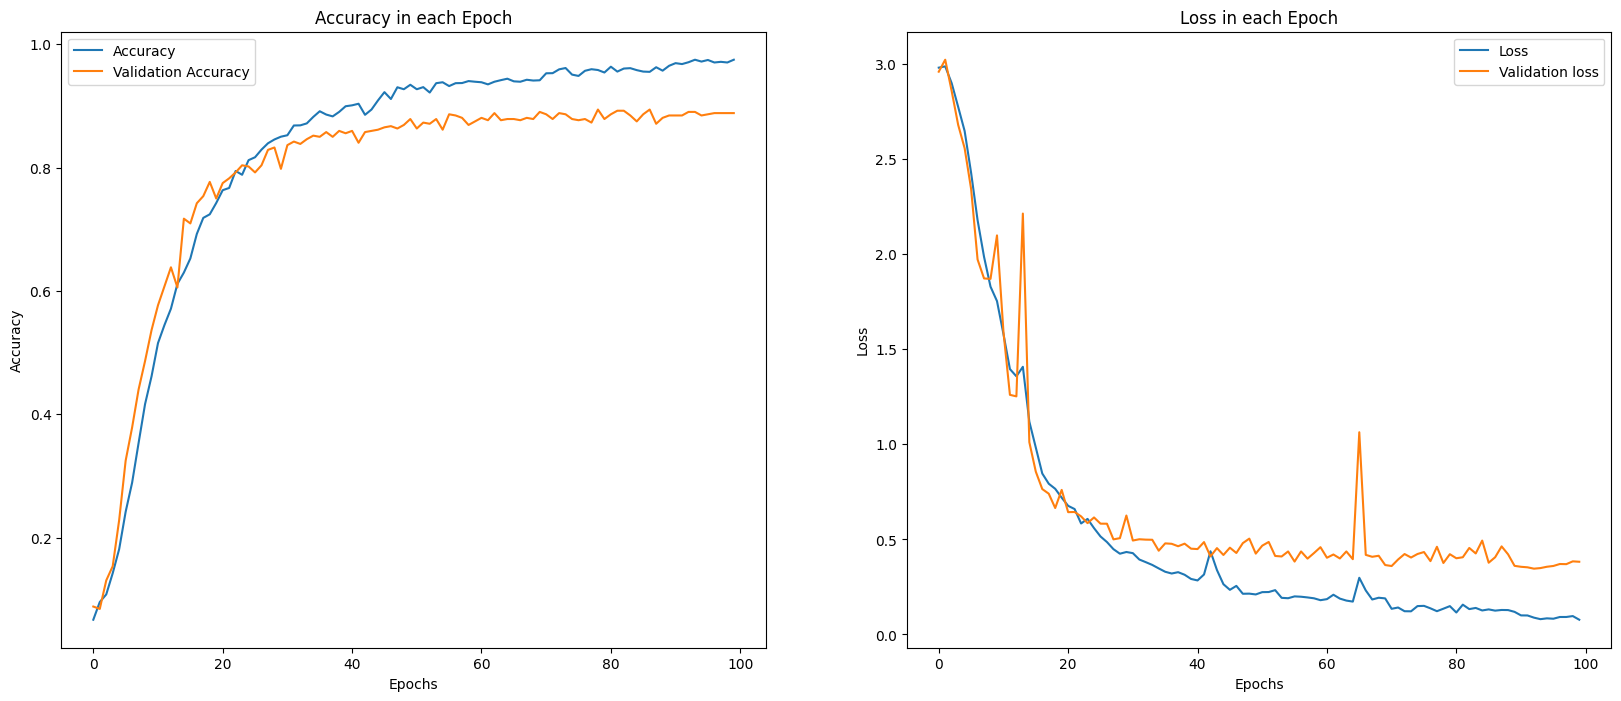

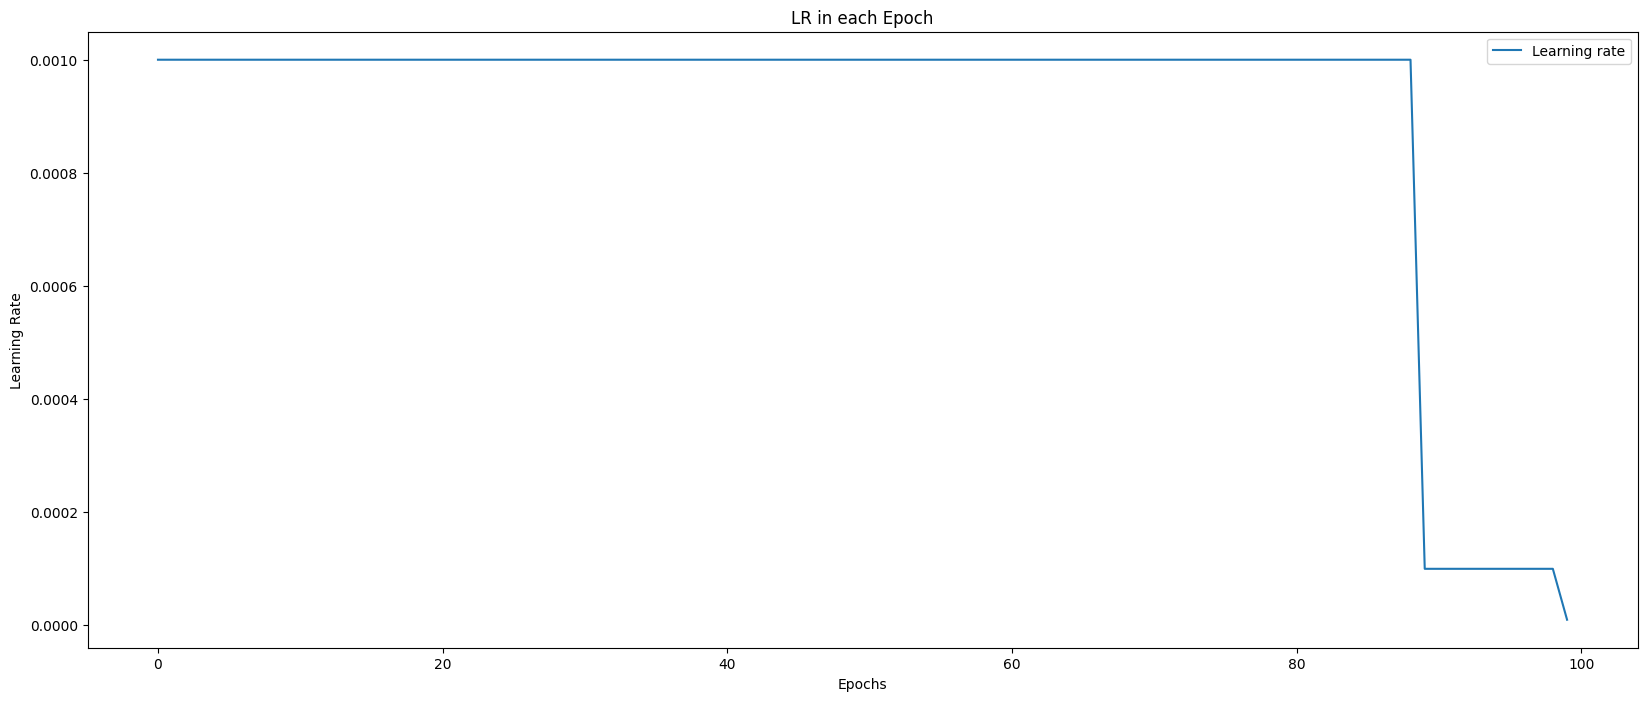

In [17]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(hitory.history['accuracy'], label='Accuracy')
plt.plot(hitory.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy in each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(hitory.history['loss'], label='Loss')
plt.plot(hitory.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss in each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show();
plt.figure(figsize=(20, 8))
plt.plot(hitory.history['learning_rate'], label='Learning rate')
plt.legend()
plt.title('LR in each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show();

## Test model

In [18]:
images = [os.path.join(base_path, path) for path in os.listdir(base_path)]
np.random.shuffle(images)
test_images = images[:16]
test_labels = [test_image.split('/')[4].split('.')[0] for test_image in test_images]

In [19]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.map(encode_single_sample)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
pred_labels = np.argmax(model.predict(test_dataset), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


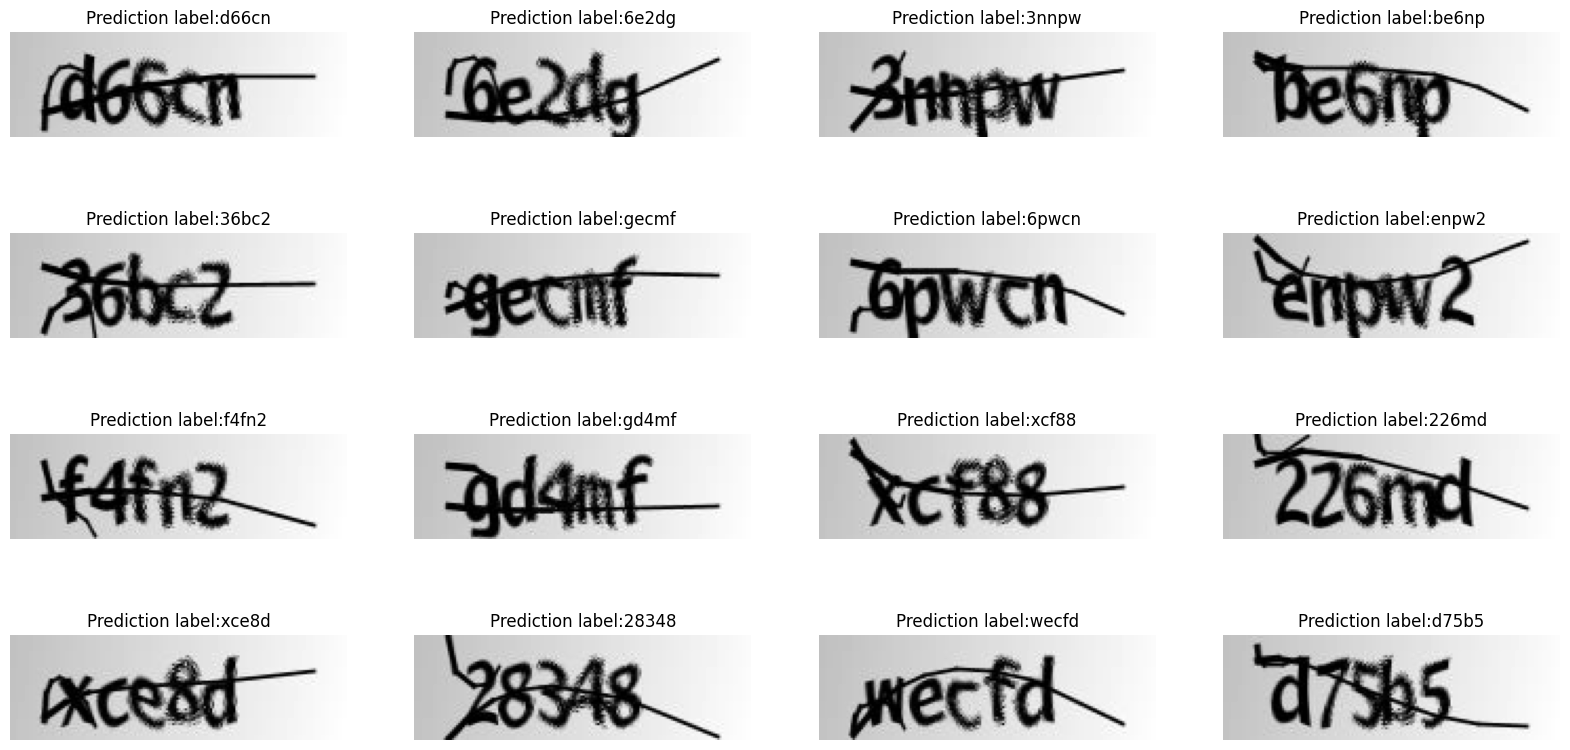

In [21]:
batch_data = next(iter(test_dataset))
images, _ = batch_data
_, axes = plt.subplots(4, 4, figsize=(20, 10))
for i in range(16):
    img = (images[i] * 255).numpy().astype('uint8')
    pred_lbl = tf.strings.reduce_join(num_to_char(pred_labels[i])).numpy().decode('UTF-8')
    axes[i // 4, i % 4].imshow(img[:, :, 0].T, cmap='gray')
    axes[i // 4, i % 4].set_title('Prediction label:' + pred_lbl)
    axes[i // 4, i % 4].axis('off')